This work was highly based on this [notebook](https://github.com/scikit-learn-contrib/MAPIE/blob/master/notebooks/regression/ts-changepoint.ipynb).

# Time series problem
Within this notebook, the "EnbPI" strategy ([Xu, Chen and Yao Xie (2021)](https://proceedings.mlr.press/v139/xu21h.html) ${}^{[1]}$) is implemented to estimate prediction intervals for time series' forecasts. In particular, the Victoria electricity demand dataset is used (as in the book: "Forecasting: Principles and Practice" by R. J. Hyndman and G. Athanasopoulos).

The electricity demand features daily and weekly seasonalities and is impacted
by the temperature, considered here as a exogeneous variable. Thus, the features for this prediction problem will be:
- The lagged `n_lag` timestamps
- The week of year
- The weekday 
- The hour of the day
- The temperature 

A Random Forest model will be used to fit the data (fine-tuning it using a randomized hyperparameters search, leveraging a sequential [`sklearn.model_selection.TimeSeriesSplit`](sklearn.model_selection.TimeSeriesSplit) cross validation), and then 'EnbPI' will be implemented through the [`mapie.time_series_regression.MapieTimeSeriesRegressor`](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieTimeSeriesRegressor.html) class.

${}^{[1]}$ Xu, Chen and Yao Xie (July 2021). “Conformal prediction interval for dynamic time-series”. In: Proceedings of the 38th International Conference on Machine Learning. Ed. Bibliography 29 by Marina Meila and Tong Zhang. Vol. 139. Proceedings of Machine Learning Research. PMLR, pp. 11559–11569. URL: https://proceedings.mlr.press/v139/xu21h.html 

We will compare 2 strategies to quantify the uncertainty: applying 'EnbPI' with or without ``partial_fit`` called at every step. 

In [1]:
import os
import json  # to serialize the best hyperparameters found
import warnings  # to suppress them

from sklearn.ensemble import RandomForestRegressor

from cp import data, visualize, validate, ts, cv, logger as _logger
import matplotlib.pyplot as plt
import numpy as np

SEED: int = 123
np.random.seed(SEED)
MISCOVERAGE: float = 0.2 # MISCOVERAGE = alpha # CONFIDENCE = 1-alpha 
logger = _logger.Logger()
warnings.filterwarnings("ignore")  # to suppress them

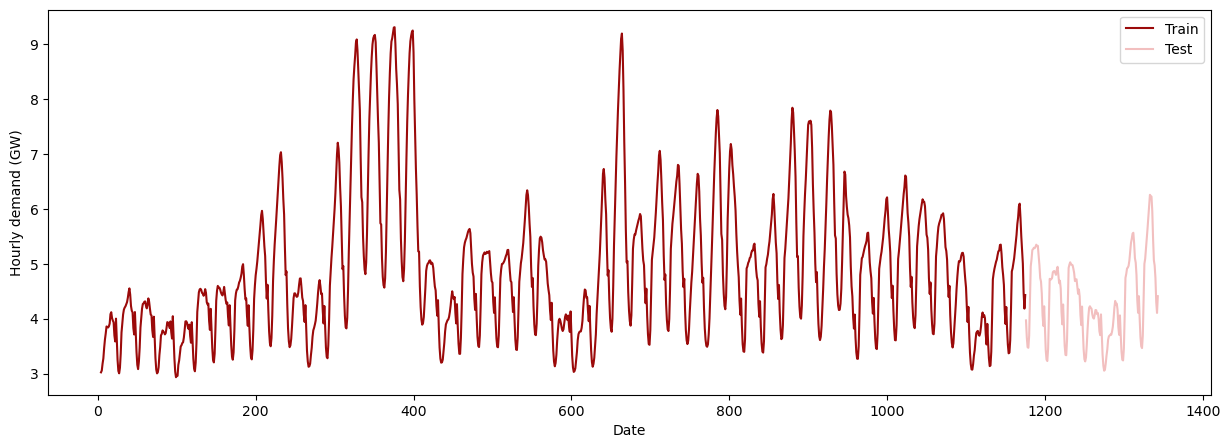

In [2]:
ts_problem = data.TimeSeriesProblem()
X_train, X_test, y_train, y_test = ts_problem.get_arrays()
ts_problem.visualize_data();

We first define perform a random search to find out which are the best hyperparameters for our random forest regressor (our base model):
- **Note:** it may take a while.

In [3]:
hyperparameters_serialization_file: str = "output/rf-hyperparameters.json"

if os.path.isfile(hyperparameters_serialization_file):
    logger.info("Retrieving best hyperparameters from local file")
    with open(hyperparameters_serialization_file, "r") as json_file:
        best_model_params: dict = json.load(json_file)
else:
    best_model_params = cv.fine_tune_rf_for_ts(X_train, y_train)
    with open(hyperparameters_serialization_file, "w") as json_file:
        json.dump(best_model_params, json_file, indent=4)

logger.info(f"The best hyperparameters found were: {best_model_params}")
best_model_params.update({'random_state': SEED, 'verbose': 0})

05/23/2024 07:32:10 AM     INFO >> Retrieving best hyperparameters from local file
05/23/2024 07:32:10 AM     INFO >> The best hyperparameters found were: {'max_depth': 23, 'n_estimators': 99}


### Training & inference

In [4]:
strategy_name: dict = {
    'EnbPI_nP': 'Ensemble of bootstrap Prediction Intervals (w/o partial fit)',
    'EnbPI': 'Ensemble of bootstrap Prediction Intervals'
}
base_model: dict = {
    'EnbPI_nP': RandomForestRegressor(**best_model_params),
    'EnbPI': RandomForestRegressor(**best_model_params)
}
y_pred, int_pred, mapie_estimator = {}, {}, {}

y_pred['EnbPI_nP'], int_pred['EnbPI_nP'], mapie_estimator['EnbPI_nP'] = ts.train_without_partial_fit(
    X_train, y_train, X_test, MISCOVERAGE, 
    RandomForestRegressor(**best_model_params)
)
y_pred['EnbPI'], int_pred['EnbPI'], mapie_estimator['EnbPI'] = ts.train(
    X_train, y_train, X_test, y_test, MISCOVERAGE, 
    RandomForestRegressor(**best_model_params)
)

05/23/2024 07:32:10 AM     INFO >> Traning EnbPI without partial fit to adjust residuals
05/23/2024 07:32:10 AM    DEBUG >>     This may take a while
05/23/2024 07:32:18 AM     INFO >> Inferring
05/23/2024 07:32:18 AM     INFO >> Traning EnbPI
05/23/2024 07:32:18 AM    DEBUG >>     This may take a while
05/23/2024 07:32:24 AM     INFO >> Inferring while adjusting residuals (partial fit)
05/23/2024 07:32:24 AM    DEBUG >>     Adjusting residuals for step 1
05/23/2024 07:32:25 AM    DEBUG >>     Adjusting residuals for step 2
05/23/2024 07:32:25 AM    DEBUG >>     Adjusting residuals for step 3
05/23/2024 07:32:25 AM    DEBUG >>     Adjusting residuals for step 4
05/23/2024 07:32:26 AM    DEBUG >>     Adjusting residuals for step 5
05/23/2024 07:32:26 AM    DEBUG >>     Adjusting residuals for step 6
05/23/2024 07:32:26 AM    DEBUG >>     Adjusting residuals for step 7
05/23/2024 07:32:27 AM    DEBUG >>     Adjusting residuals for step 8
05/23/2024 07:32:27 AM    DEBUG >>     Adjusting r

### Computing metrics

In [5]:
coverages: dict = validate.coverage(int_pred, y_test)
widths: dict = validate.width(int_pred)
rmse: dict = validate.rmse(y_pred, y_test)
cwc: dict = validate.cwc(int_pred, y_test, MISCOVERAGE, eta=10)

05/23/2024 07:33:21 AM     INFO >> Validating EnbPI_nP coverage
05/23/2024 07:33:21 AM     INFO >> Validating EnbPI coverage
05/23/2024 07:33:21 AM     INFO >> Validating EnbPI_nP width
05/23/2024 07:33:21 AM     INFO >> Validating EnbPI width
05/23/2024 07:33:21 AM     INFO >> Validating EnbPI_nP RMSE
05/23/2024 07:33:21 AM     INFO >> Validating EnbPI RMSE
05/23/2024 07:33:21 AM     INFO >> Validating EnbPI_nP CWC
05/23/2024 07:33:21 AM     INFO >> Validating EnbPI CWC


## Plotting

Let's first visualize the predicted values and intervals

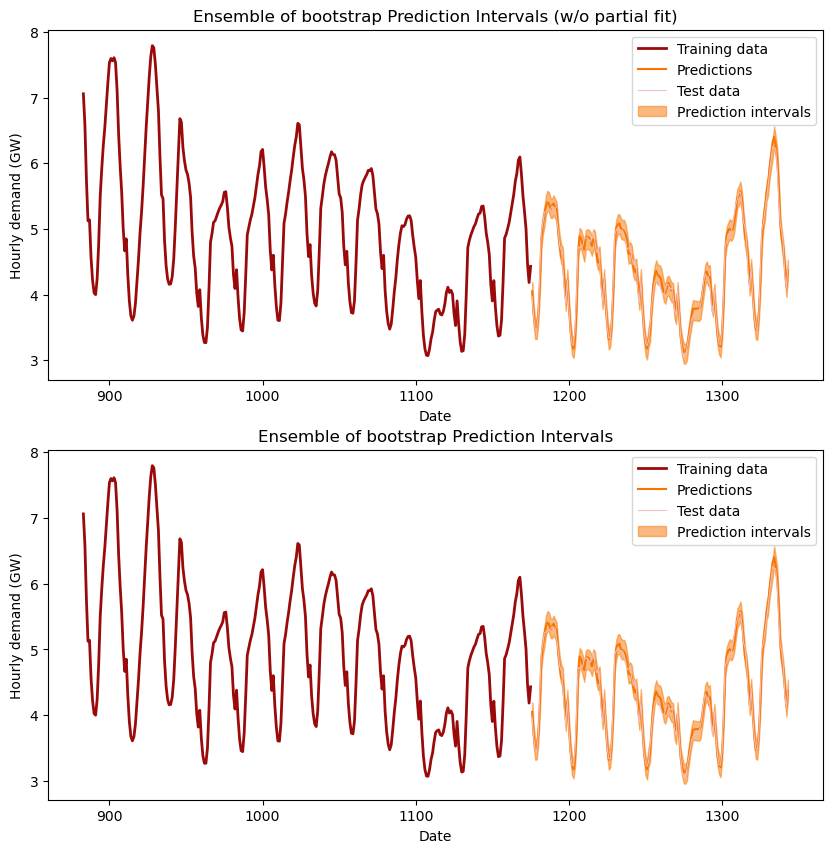

In [6]:
n_figs: int = len(base_model)
fig, axs = plt.subplots(nrows=n_figs, figsize=(10, 5 * n_figs));

for _i, _strat in enumerate(strategy_name.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = visualize.ts(
        points={
            'X_train': ts_problem.train_df.index.values, 
            'X': ts_problem.test_df.index.values, 
            'y_train': y_train,
            'y': y_test,
            'y_pred': y_pred[_strat],
            },
        intervals={
            'X': ts_problem.test_df.index.values, 
            'y_low': _y_pred_low, 
            'y_up': _y_pred_up
            },
        title=strategy_name[_strat], 
        ax=axs[_i]
        )
    
plt.savefig('output/prediction-intervals-timeseries-problem.png', dpi=200)
plt.show()
plt.close()

Let us assess some metrics and plot different validation figures:

In [21]:
from typing import Dict

def _subsample(data: Dict, ref: np.ndarray, subsample: float = None) -> Dict:
    if subsample is not None:
        indices = np.random.choice(
            range(len(ref)), replace=False,
            size=int(len(ref) * subsample))

    return {_k: _v[indices] for _k, _v in data.items()}

C_STRONG: str = '#9B0A0A'
C_MEDIUM: str = '#800000'
C_LIGHT: str = '#F2BFBF'
C_PRED: str = '#F87500'

def goodness(
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    coverage,
    width,
    rmse,
    cwc,
    ax=None,
    subsample=None,
    **kwargs
):
    
    if subsample is not None:
        _subset = _subsample(
            {'test': y_test, 'pred': y_pred, 
            'low': lower_bound, 'up': upper_bound}, 
            y_test, subsample)
        y_test, y_pred = _subset['test'], _subset['pred']
        lower_bound, upper_bound = _subset['low'], _subset['up']

    if ax is None:
        _, ax = plt.subplots()

    _outside = (y_test > upper_bound) + (y_test < lower_bound)
    error = np.zeros((2, len(y_pred)))
    error[0, :] = y_pred - lower_bound
    error[1, :] = upper_bound - y_pred
    ax.errorbar(
        y_test[~_outside],
        y_pred[~_outside],
        yerr=error[:, ~_outside],
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        color=C_STRONG,
        label="Inside PI"
        )
    ax.errorbar(
        y_test[_outside],
        y_pred[_outside],
        yerr=error[:, _outside],
        capsize=5, marker="o", elinewidth=2, linewidth=0, 
        color=C_LIGHT,
        label="Outside PI"
        )
    ax.scatter(
        y_test[_outside],
        y_test[_outside],
        marker="*", color="black",
        label="True value"
    )
    ax.legend(loc='lower right')
    ax.set_xlabel(kwargs.get('xlabel', "Groundtruth"))
    ax.set_ylabel(kwargs.get('ylabel', "Prediction"))

    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")

    # and finally, some metrics as text
    ax.annotate(
        f"Coverage: {np.round(coverage, 3)}\n"
        + f"Interval width: {np.round(width, 3)}\n"
        + f"CWC: {np.round(cwc, 3)}\n"
        + f"RMSE: {np.round(rmse, 3)}",
        xy=kwargs.get('xy', (0.,0.)), # point to annotate
        xytext=kwargs.get('xytext', (np.min(y_test) * 1.175, np.max(y_pred) * 0.72)), 
        bbox=dict(boxstyle="round", fc="white", ec="grey", lw=1)
    )

    if 'title' in kwargs:
        ax.set_title(kwargs['title'], fontweight='bold')
    
    if ax is None:
        plt.savefig(kwargs.get('save_path', 'output/goodness.png'), dpi=200)
        plt.show()
        plt.close()
        return

    return ax

- **Average goodness**

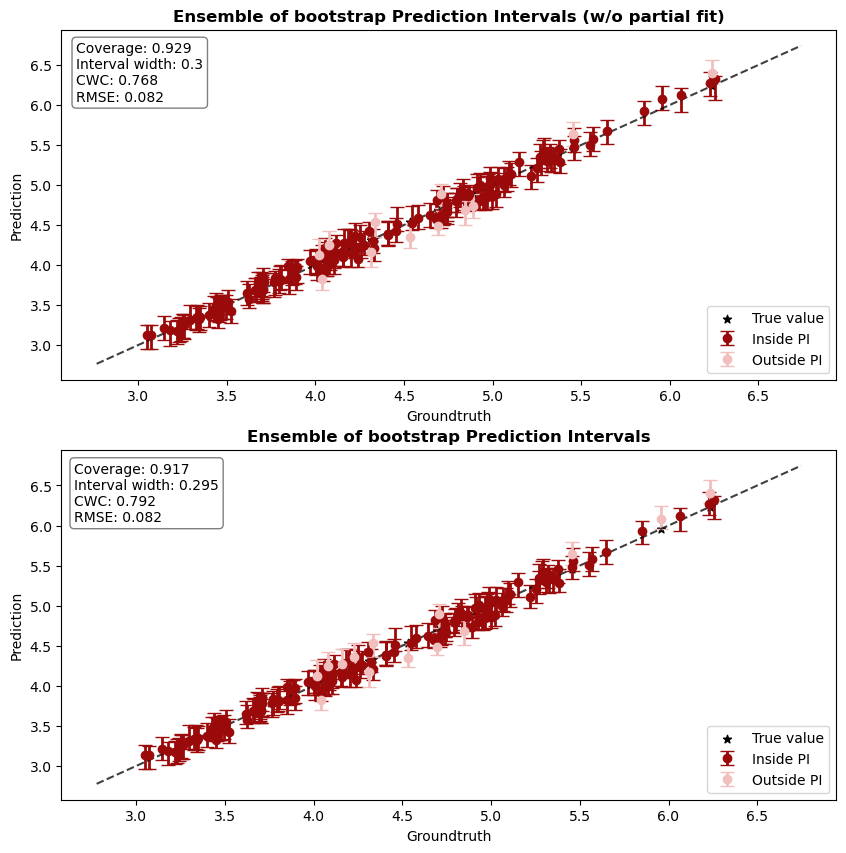

In [31]:
n_figs = len(base_model)
fig, axs = plt.subplots(nrows=n_figs, figsize=(10, 5 * n_figs));

for _i, _strat in enumerate(strategy_name.keys()):
    # Predicted intervals
    _y_pred_low = int_pred[_strat][:, 0, 0].ravel()
    _y_pred_up = int_pred[_strat][:, 1, 0].ravel()

    # Visualize
    axs[_i] = goodness(
        y_test, y_pred[_strat],
        _y_pred_low, 
        _y_pred_up,
        coverages[_strat],
        widths[_strat],
        rmse[_strat],
        cwc[_strat],
        ax=axs[_i],
        fading_with_lead_time=True if _strat == 'EnbPI_nP' else False,
        xy=(5., 4.),
        xytext=(2.65, 6.05),
        # subsample=0.25,
        title=strategy_name[_strat], 
    )
plt.savefig('output/average-goodness-timeseries-problem.png', dpi=200)
plt.show()
plt.close()